In [49]:
from src.PreProcess import getDegreeSequences
import networkx as nx
import pandas as pd
from src.struc2vec import struc2vec
from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
from src.GraphAlgorithms import GraphAlgorithms as ga

In [51]:
df = pd.read_excel("src/UN_full.xlsx")

In [52]:
edgelist = [(origin, destination, {"weight":weight}) for origin, destination, weight in df[["origin","destination","weight_scaled"]].values]

In [53]:
G_D = nx.DiGraph(edgelist)
# G_UD = nx.Graph(edgelist)

In [54]:
# Let's start by getting the adjacency matrix
A = nx.adjacency_matrix(G_D).toarray()

In [55]:
for i in range(len(A)):
    A[i,:] /= A[i,:].sum()

In [56]:
# For convenience, let's make it into a pandas dataframe
df = pd.DataFrame(A).stack().reset_index()
df.columns = ("source", "target", "weight")
df = df[df["weight"] > 0]

In [57]:
indexNodes = {i: node for i, node in enumerate(G_D.nodes())}

In [58]:
quat25 = df["weight"].describe()["25%"]

In [59]:
removeEdges = [(indexNodes[int(origin)], indexNodes[int(destination)]) for [origin, destination, weight] in df[df["weight"]<quat25].values]

In [60]:
for (origin, destination) in removeEdges:
    G_D.remove_edge(origin, destination)

In [61]:
weights = np.array([edge[2]["weight"] for edge in G_D.edges(data=True)])

In [62]:
def scale_x(x):
    min_weight = np.min(weights)
    max_weight = np.max(weights)
    min_scale = 0.1
    max_scale = 5
    return (((max_scale-min_scale)*(x-min_weight))/(max_weight-min_weight))+min_scale

In [63]:
weights_scaled = [scale_x(w) for w in weights]

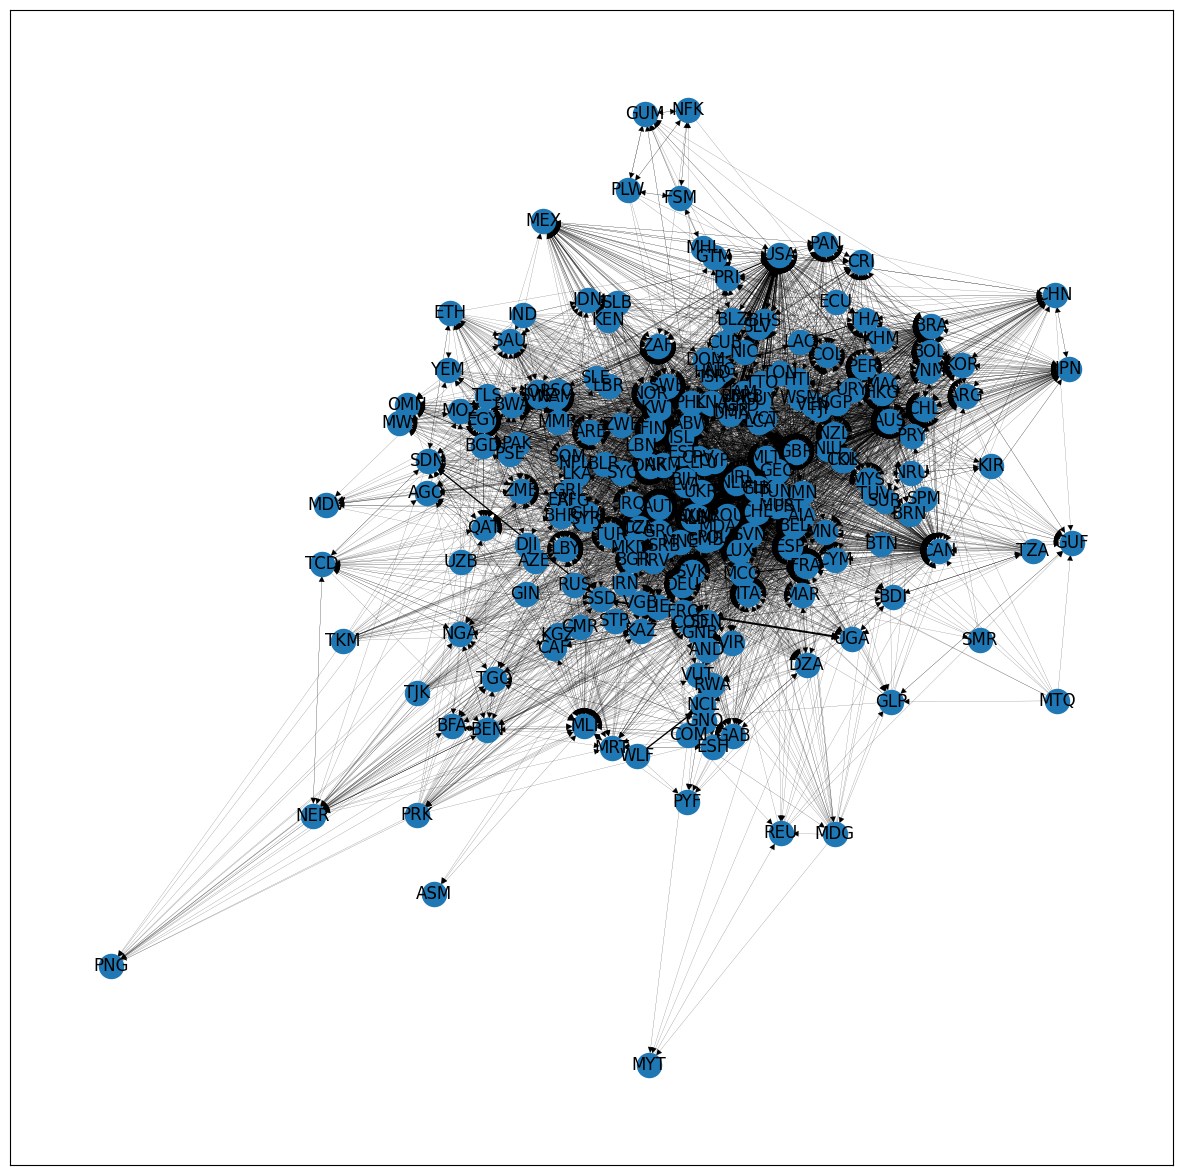

In [64]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_networkx(G_D, width=weights_scaled)

In [65]:
G_UD = nx.Graph(G_D)

In [66]:
s2vG = struc2vec(G_D)

In [67]:
s2vG.getMultiLevelGraph()

In [71]:
for i, G in s2vG.G_ML.items():
    nx.write_gexf(G, f"GML/{i}.gexf")

In [83]:
walks = s2vG.getRandomWalks(number_of_walks = 1000, walk_length=40)

In [84]:
model = Word2Vec(walks, vector_size=75)

In [85]:
embeddings = {node: model.wv[node] for node in s2vG.nodes}

In [86]:
X = np.array(list(embeddings.values()))

In [87]:
pca = PCA(n_components=3)
X_transform = pca.fit_transform(X)

In [88]:
node_embeddings = {}
for node, embedding in enumerate(X_transform):
    emb_list = list(embedding)
    index = emb_list.index(max(emb_list))
    node_embeddings[node] = index

In [89]:
cmap = {0:"green",1:"yellow", 2:"red"}
nodecolors = [cmap[v] for k,v in node_embeddings.items()]

In [ ]:
# Change to scaling instead!
weights = [min(edge[2]["weight"],3) for edge in s2vG.G_D.edges(data=True)]

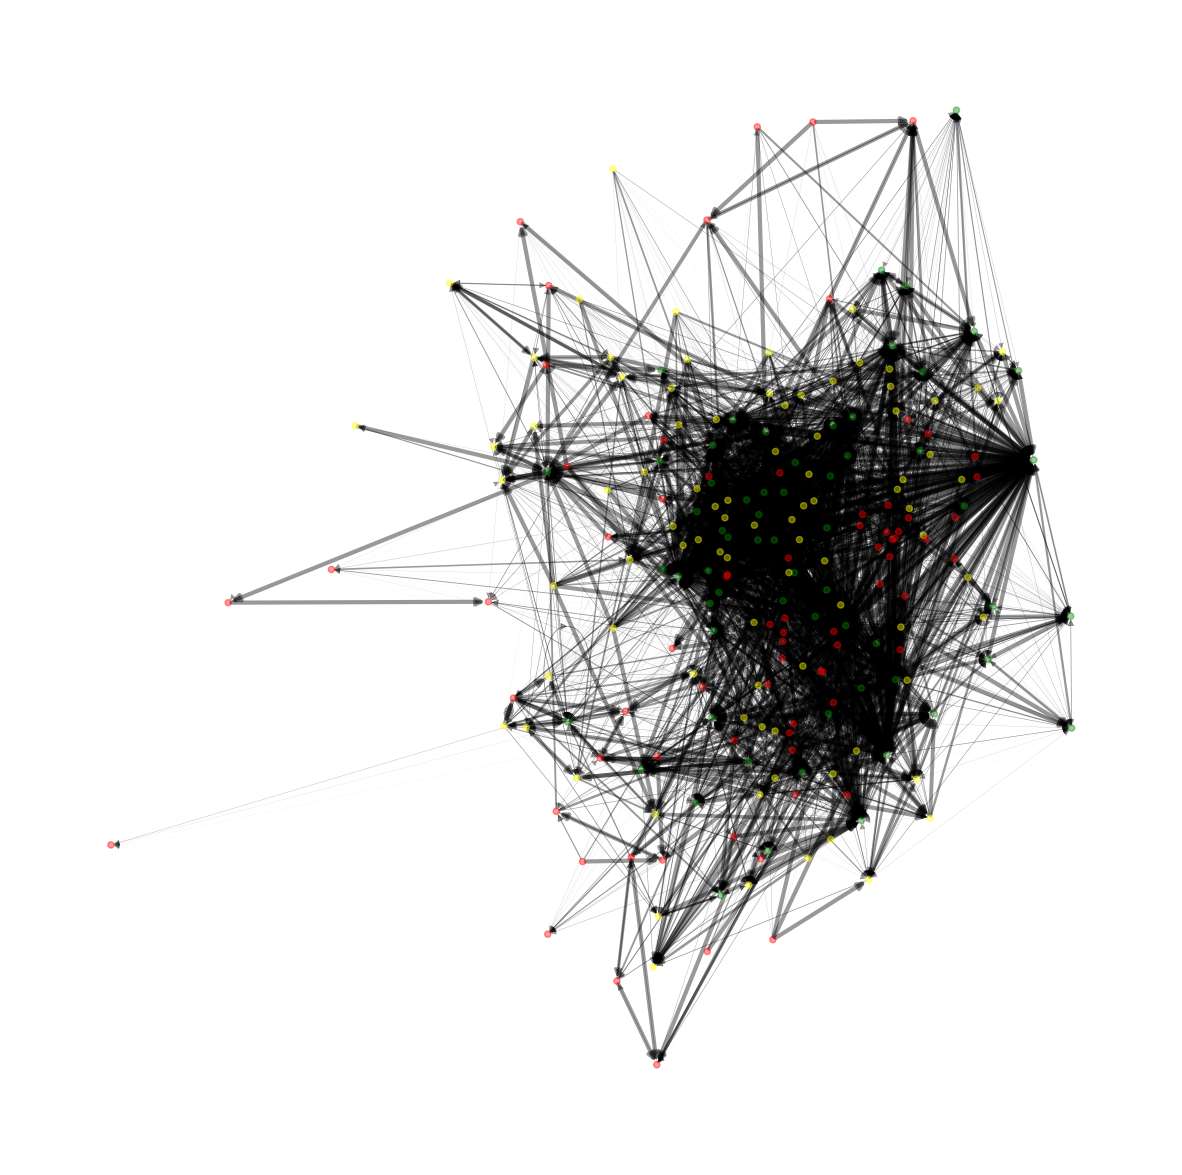

In [91]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_spring(s2vG.G_D, with_labels=False, node_color=nodecolors, width = weights, node_size=20, alpha=0.4)